In [1]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 300
BATCH_SIZE   = 24
NUM_CLASSES  = 5
CHANNEL_SIZE = 3

pre_process = "300_ben_normal_"

# pre_process = "ben_weird_"

# pre_process = "clahe_green_"


Using TensorFlow backend.


# Loading data

In this kernel, we are using multilabel data. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. 

The idea is that if an eye has severe diabetic retinopathy, that also means that it has moderate and severe diabetic retinopathy

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()


           id_code  diagnosis          original  \
2929  cb28adab4e8a          0  cb28adab4e8a.png   
2930  cb2f3c5d71a7          1  cb2f3c5d71a7.png   
2931  cb39761f0712          0  cb39761f0712.png   

                            processed  
2929  300_ben_normal_cb28adab4e8a.png  
2930  300_ben_normal_cb2f3c5d71a7.png  
2931  300_ben_normal_cb39761f0712.png  


Text(0.5, 1.0, 'Samples Per Class')

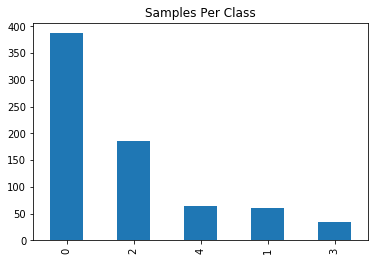

In [2]:
# data frame of current competition
df_2019 = pd.read_csv(f"../aptos2019/train.csv") 
df_2019.processed = df_2019.id_code.apply(lambda x: pre_process + x + ".png")
df_2019["original"]  = df_2019.id_code.apply(lambda x: x + ".png")
df_2019["processed"] = df_2019.original.apply(lambda x: pre_process + x)
train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False)

# 2019 data frame 
df_2015 = pd.read_csv(f"../aptos2015/trainLabels.csv") 
df_2015 = df_2015[:6000]
df_2015["original"]  = df_2015.image.apply(lambda x: x + ".jpeg")
df_2015["processed"] = df_2015.original.apply(lambda x: pre_process + x)
df_2015["diagnosis"] = df_2015.level
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)

valid_2019['diagnosis'].value_counts().plot(kind='bar')
print(valid_2019[:3])
plt.title('Samples Per Class')


In [3]:
def label_convert(y_val):
    y_val = y_val.astype(int).sum(axis=1) - 1
    return y_val

def get_train_valid_df(year="2019", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(x+1)])
    valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(x+1)])

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())

        for diagnosis in range(5):
            indexes_valid = valid[valid['diagnosis'] == diagnosis].index
            indexes_train = train[train['diagnosis'] == diagnosis].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution
    train = train.sample(frac=0.8)
    valid = valid.sample(frac=0.8)
    
    return train, valid

df_sample, _ = get_train_valid_df(year="2019")
print(df_sample.head())

           id_code  diagnosis          original  \
146   0ad7f631dedb          1  0ad7f631dedb.png   
1104  4df6a81b476e          3  4df6a81b476e.png   
2756  bebb3f167654          1  bebb3f167654.png   
2443  a9e984b57556          3  a9e984b57556.png   
554   274f5029189b          1  274f5029189b.png   

                            processed        labels  
146   300_ben_normal_0ad7f631dedb.png        [0, 1]  
1104  300_ben_normal_4df6a81b476e.png  [0, 1, 2, 3]  
2756  300_ben_normal_bebb3f167654.png        [0, 1]  
2443  300_ben_normal_a9e984b57556.png  [0, 1, 2, 3]  
554   300_ben_normal_274f5029189b.png        [0, 1]  


In [4]:
# # display some data
# def display_data():
#     df_example, _ = get_train_valid_df(year="2019")

#     # Display some random images from Data Set with class categories.
#     figure=plt.figure(figsize=(22,20))
#     for target_class in range(5):
#         for i, file_name in enumerate(df_example[df_example.diagnosis == target_class].original.sample(2)):
            
#             # open the file
#             o_img = cv2.imread(f"../aptos2019/train_images/{file_name}")
#             p_img = cv2.imread(f"../aptos2019/train_images/{pre_process}{file_name}")

#             o_rgb = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB)
#             p_rgb = cv2.cvtColor(p_img, cv2.COLOR_BGR2RGB)
            
#             ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
#             plt.imshow(o_rgb)
#             ax.set_title(target_class)
            
#             ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
#             plt.imshow(p_rgb)
#             ax.set_title(target_class)
            
# display_data()

In [5]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True and (jitter > 0.01), 
                                       vertical_flip=True and (jitter > 0.01),
                                       rotation_range=int(800*jitter),
                                       brightness_range=[1-jitter, 1+jitter],
                                       channel_shift_range=int(30*jitter),
                                       zoom_range=[(1-jitter), (1+jitter/2)],
                                       fill_mode="reflect",
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="processed", 
                                       y_col='labels', 
                                       class_mode="categorical", 
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019", even_distrib=True):
    
    train, valid = get_train_valid_df(year=year, even_distrib=even_distrib) 
    datagen = dataGenerator(jitter)
    
    train_gen = datagen_with_flow(datagen, train, f"../aptos{year}/train_images/")
    valid_gen = datagen_with_flow(datagen, valid, f"../aptos{year}/train_images/")
    
    return train_gen, valid_gen

gc.collect()


125

Found 632 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.


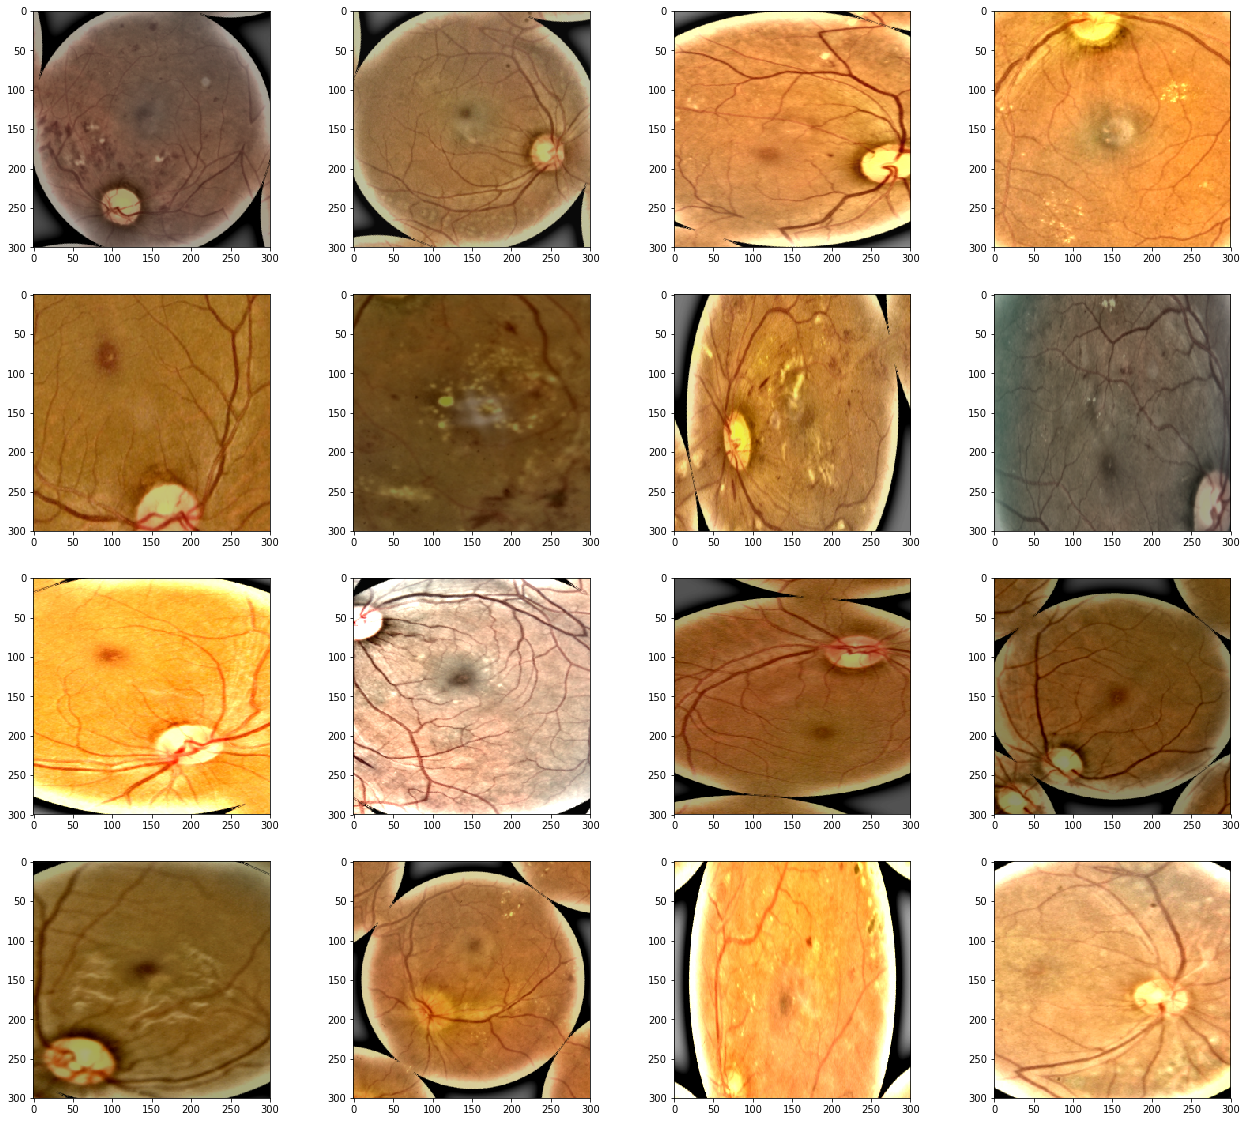

In [6]:
train_sample_gen, valid_sample_gen = generator(jitter=0.5)

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in valid_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break

In [7]:
class Metrics(Callback):
    def __init__(self, generator):
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        numBatches = 20
        y_pred     = []
        y_val      = []
        for x, y in self.generator:
            predictions = model.predict(x) 
            y_pred.extend(label_convert(predictions > 0.5))
            y_val.extend(label_convert(y))
            
            numBatches -= 1
            if numBatches <= 0:
                break
            
        val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(val_kappa)
        
        print(confusion_matrix(y_val, y_pred), val_kappa)
            
        if val_kappa == max(self.val_kappas) and val_kappa > 0.85:
            gc.collect()
            print("Max of this run, saving model.")
            model.save(f"{pre_process}-{val_kappa:.4f}.h5")


In [8]:
def create_model():
    
    model = Sequential()
    model.add(DenseNet121(weights='../DenseNet-BC-121-32-no-top.h5', 
#     model.add(DenseNet121(weights=None, 
                          include_top=False, 
                          input_shape=(IMG_DIM, IMG_DIM, CHANNEL_SIZE)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    return model

model = create_model()
# model.load_weights("ben_normal_-0.8863.h5")
# model.load_weights("ben_weird_-0.8784.h5")



W0817 14:53:15.423490 139877820704512 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 14:53:15.442514 139877820704512 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 14:53:15.448208 139877820704512 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 14:53:15.470741 139877820704512 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The n

In [10]:
for year in ["2019", "2015", "2019"]:
    for jitter in [0.5, 0.2, 0.05]:
    
        model.compile(optimizer=Adam(lr=0.00003*jitter), loss='binary_crossentropy',  metrics=['accuracy'])

        print("           -----------------------------------", year, 
              jitter, "-----------------------------------")

        for even_distrib in [True, True, True, False]:

            print("           -   -   -   -   -   -   -   -   ", 
                  even_distrib, "-   -   -   -   -   -   -   -   -")
            
            # these need to be global for the kappa callback
            train_generator, valid_generator = generator(jitter=jitter, year=year, even_distrib=even_distrib)

            # Call backs during training            
            kappa_callbacks = Metrics(valid_generator)
            reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                                           min_lr=1e-8, mode='auto', verbose=1)

            # train the model for 12 epochs
            history = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                          validation_data=valid_generator,
                                          validation_steps=valid_generator.n // valid_generator.batch_size,
                                          epochs=3, workers=4, verbose=1,
                                          callbacks=[reduce_lr, kappa_callbacks],
                                         )
    
    gc.collect()

           ----------------------------------- 2019 0.5 -----------------------------------
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 632 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.
Epoch 1/3
26/26 [==============================] - 94s 4s/step - loss: 0.5390 - acc: 0.7381 - val_loss: 0.5354 - val_acc: 0.7583
[[19 31 27  5  1]
 [ 2 21 47 23  6]
 [ 1 10 31 35 18]
 [ 0  3 23 51 14]
 [ 0 12 30 45  9]] 0.4063488573766687
Epoch 2/3
26/26 [==============================] - 35s 1s/step - loss: 0.4834 - acc: 0.7689 - val_loss: 0.5047 - val_acc: 0.7569
[[44 21 15  4  1]
 [ 5 30 34 23  8]
 [ 3  7 23 42 17]
 [ 0  0 17 62 14]
 [ 0 10 20 56 12]] 0.5448635921584686
Epoch 3/3
26/26 [==============================] - 32s 1s/step - loss: 0.4428 - acc: 0.7974 - val_loss: 0.4541 - val_acc: 0.8052
[[50 20 12  3  0]
 [ 7 14 33 38  8]
 [ 7  4 14 53 19]
 [ 0  0  3 75 11]
 [ 2  4 18 53 16]] 0.55714

Epoch 1/3
26/26 [==============================] - 103s 4s/step - loss: 0.3094 - acc: 0.8593 - val_loss: 0.2627 - val_acc: 0.8767
[[80  1  0  0  0]
 [14 38 34  7  0]
 [ 2  6 63 15  1]
 [ 0  0 38 56  6]
 [ 1  8 43 37 14]] 0.7161351933542776
Epoch 2/3
26/26 [==============================] - 32s 1s/step - loss: 0.2980 - acc: 0.8635 - val_loss: 0.2843 - val_acc: 0.8621
[[83  1  0  0  0]
 [16 45 32  3  0]
 [ 5  5 69  8  1]
 [ 0  1 35 63  1]
 [ 1 11 44 39  5]] 0.7035087719298245
Epoch 3/3
26/26 [==============================] - 32s 1s/step - loss: 0.3124 - acc: 0.8606 - val_loss: 0.3195 - val_acc: 0.8724

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.500000053056283e-07.
[[78  1  0  0  0]
 [22 41 33  2  0]
 [ 8  5 71  6  0]
 [ 0  0 34 60  2]
 [ 4 11 48 29 13]] 0.6759156084433605
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 632 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes

15/15 [==============================] - 18s 1s/step - loss: 0.6482 - acc: 0.7279 - val_loss: 0.6841 - val_acc: 0.6848
[[79  0  0  0  0]
 [78  0  1  0  0]
 [70  0  2  0  0]
 [45  7 20  4  5]
 [39  9 12  3  1]] 0.1852116343283685
Epoch 3/3
15/15 [==============================] - 18s 1s/step - loss: 0.6128 - acc: 0.7375 - val_loss: 0.7473 - val_acc: 0.6606

Epoch 00003: ReduceLROnPlateau reducing learning rate to 6.000000212225132e-07.
[[82  0  0  0  0]
 [80  0  0  0  0]
 [72  3  0  0  0]
 [56  9 10  6  2]
 [47  8 13  2  0]] 0.13478096983762133
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 364 validated image filenames belonging to 5 classes.
Found 57 validated image filenames belonging to 5 classes.
Epoch 1/3
15/15 [==============================] - 25s 2s/step - loss: 0.5868 - acc: 0.7333 - val_loss: 0.7753 - val_acc: 0.7125
[[86  0  0  0  0]
 [61  0  0  0  0]
 [67  4  9  4  0]
 [34  6 32  2  4]
 [37  4 15 10  0]] 0.24851419294393629
Epoch 2/

[[88  0  0  0  0]
 [61 14 22  3  0]
 [20 14 44 15  0]
 [10 11 25 52  1]
 [22 10 26 30  0]] 0.49421809142980655
Epoch 3/3
26/26 [==============================] - 33s 1s/step - loss: 0.3102 - acc: 0.8676 - val_loss: 0.3781 - val_acc: 0.8345
[[88  0  0  0  0]
 [29 25 36  4  0]
 [10 13 47 24  0]
 [ 2  7 28 63  1]
 [ 8  9 26 40  4]] 0.6452849289406191
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 632 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.
Epoch 1/3
26/26 [==============================] - 41s 2s/step - loss: 0.2899 - acc: 0.8782 - val_loss: 0.3471 - val_acc: 0.8567
[[84  2  0  0  0]
 [26 30 26 10  0]
 [ 9  5 40 34  0]
 [ 0  5 23 67  0]
 [ 9 11 27 53  3]] 0.6389570296414379
Epoch 2/3
26/26 [==============================] - 33s 1s/step - loss: 0.2758 - acc: 0.8750 - val_loss: 0.3260 - val_acc: 0.8707
[[82  0  0  0  0]
 [19 37 28 11  0]
 [ 4  3 45 36  1]
 [ 0  0 17 79  0]
 [ 5 11

26/26 [==============================] - 33s 1s/step - loss: 0.2370 - acc: 0.8974 - val_loss: 0.2088 - val_acc: 0.9138

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.500000053056283e-07.
[[96  4  0  0  0]
 [ 9 26 42  3  0]
 [ 0  8 63 18  2]
 [ 0  0 22 70  8]
 [ 3  1 28 30 35]] 0.8106313270030605
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 632 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.
Epoch 1/3
26/26 [==============================] - 41s 2s/step - loss: 0.2082 - acc: 0.9119 - val_loss: 0.1887 - val_acc: 0.9167
[[87  0  0  0  0]
 [ 6 45 44  2  0]
 [ 0 10 67 22  0]
 [ 0  0 17 65  6]
 [ 0  0 27 40 26]] 0.835809887416213
Epoch 2/3
26/26 [==============================] - 33s 1s/step - loss: 0.2511 - acc: 0.8900 - val_loss: 0.1999 - val_acc: 0.9086
[[93  0  0  0  0]
 [ 6 50 43  0  0]
 [ 0  9 71 21  0]
 [ 0  0 16 66  6]
 [ 0  1 27 34 25]] 0.8425618146721239
Epoch 3/3


In [ ]:
model.save(f"{pre_process}-201[59]-run.h5")

# Compare the average of 5 randomised jitters to a non-jittered val

In [ ]:
# def compare_prediction_process(year="2019"):

#     _, valid_df = get_train_valid_df(year=year, even_distrib=False)
    
#     y_val  = valid_df.diagnosis.astype(int)

#     # with jitter
#     num = 7
#     prediction_lists = np.zeros((valid_df.index.size, num, 5))
#     for i in range(num):
#         datagen = datagen_with_flow(dataGenerator(0.03), valid_df, f"../aptos{year}/train_images/")
#         prediction_lists[:, i] = model.predict_generator(generator=datagen, steps=len(datagen), workers=4, verbose=1)

#     predictions = np.median(prediction_lists, axis=1)
#     y_pred = label_convert(predictions > 0.5)
    
#     print("With jitter: ", cohen_kappa_score(y_val, y_pred, weights='quadratic'))
#     print(confusion_matrix(y_val, y_pred))
          
#     # no jitter
#     datagen = datagen_with_flow(dataGenerator(0), valid_df, f"../aptos{year}/train_images/")
#     predictions = model.predict_generator(generator=datagen, steps=len(datagen), workers=4, verbose=1)
#     y_pred = label_convert(predictions > 0.5)
    
#     print("With no jitter: ", cohen_kappa_score(y_val, y_pred, weights='quadratic'))
#     print(confusion_matrix(y_val, y_pred))
            
    
# compare_prediction_process("2019")
# gc.collect()